In [207]:
import pandas as pd
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [208]:
noise = pd.read_csv('data_noisy_gain0', header=None, skip_blank_lines=False)
noise[0] = noise[0].str.replace("(", "")
noise[1] = noise[1].str.replace(")", "")

noise = noise.astype(float)
noise[2] = np.sqrt(noise[0]**2 + noise[1]**2) #power level of the 
noise[2] = 10*np.log10(noise[2]) #RSS

noise[3] = noise.index / len(noise) * 10

noise = noise.replace([np.inf, -np.inf], np.nan)
noise = noise.dropna(axis = 0, inplace=False)

# noise = noise[noise[2] <= 0]
noise_floor = sum(noise[2]) / len(noise[2])
print(noise_floor)
print(noise)

/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


-277.00472805545354
                     0              1            2         3
0         9.765920e-04  -4.882960e-04   -29.618318  0.000000
8        -9.765920e-04   0.000000e+00   -30.102868  0.000042
12        0.000000e+00  -9.765920e-04   -30.102868  0.000063
40       2.590280e-144  6.879150e-154 -1435.866533  0.000210
43        3.845790e-86   1.246360e-47  -469.043565  0.000226
...                ...            ...          ...       ...
1900255   2.886830e+74  6.940230e-310   744.604212  9.999574
1900271  2.599040e-144   0.000000e+00 -1435.851870  9.999658
1900291  1.817770e-306   3.139470e-63  -625.031437  9.999763
1900325   2.886830e+74  6.940200e-310   744.604212  9.999942
1900331  9.519900e-307  6.013470e-154 -1532.208749  9.999974

[83545 rows x 4 columns]


In [209]:
drone = pd.read_csv('data_drone_gain0', header=None, skip_blank_lines=False)
drone[0] = drone[0].str.replace("(", "")
drone[1] = drone[1].str.replace(")", "")

drone = drone.astype(float)
drone[2] = (drone[0]**2 + drone[1]**2) #power level of the 
drone[2] = 10*np.log10(drone[2]) #RSS

drone[3] = drone.index / len(drone) * 10

drone = drone.replace([np.inf, -np.inf], np.nan)
drone = drone.dropna(axis = 0, inplace=False)


drone = drone[drone[2] <= 0]
drone = drone[drone[2] >= noise_floor]
# drone[2] = drone[2].apply(lambda x: max(x, noise_floor))

drone = drone.rename({0: 'i', 1: 'q', 2: 'rss', 3: 'time'}, axis=1)

/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


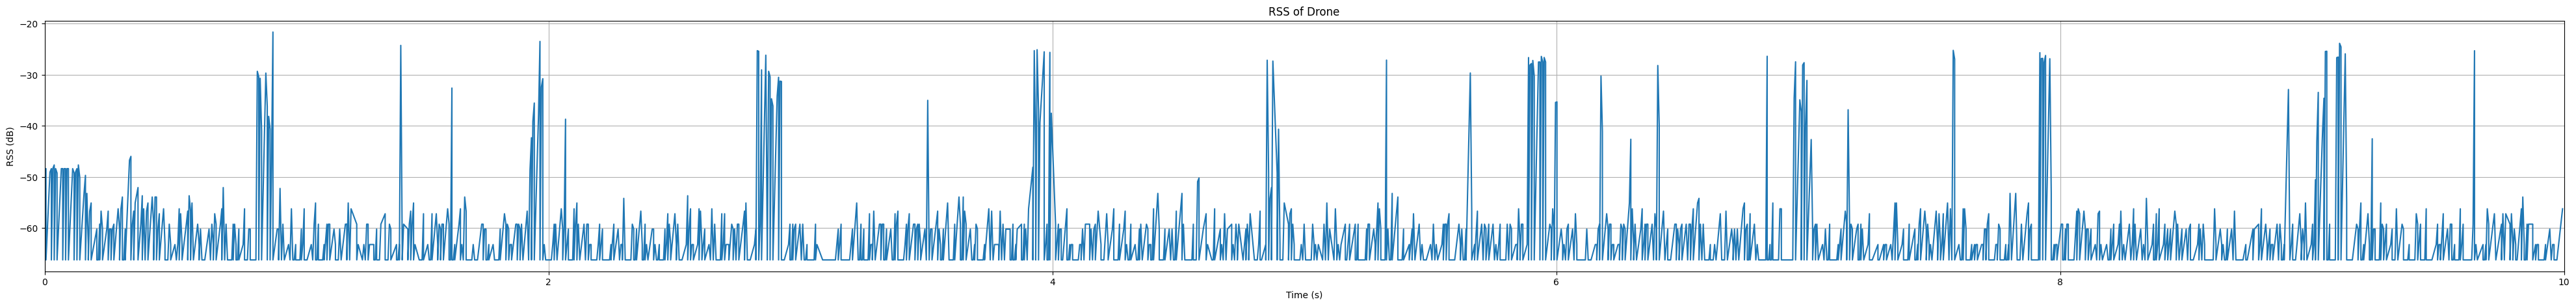

In [210]:
drone = drone[drone['rss'] >= -90]
plt.figure(figsize=(50, 5))
# plt.plot(drone[3][:200], drone[2][:200])
plt.plot(drone['time'], drone['rss'])
plt.title('RSS of Drone')
plt.xlabel('Time (s)')
plt.xlim([0, 10])
plt.ylabel('RSS (dB)')
plt.grid(True)
plt.show()

In [213]:
average = drone['rss'].mean() + 10

drone['rolling_rss'] = drone['rss'].rolling(window=8).mean()
drone = drone[drone['rss'] >= -90]

parts = drone.copy()
parts.loc[parts.rolling_rss <= average, 'rolling_rss'] = 0
parts['rolling_rss'] = parts['rolling_rss'].abs()

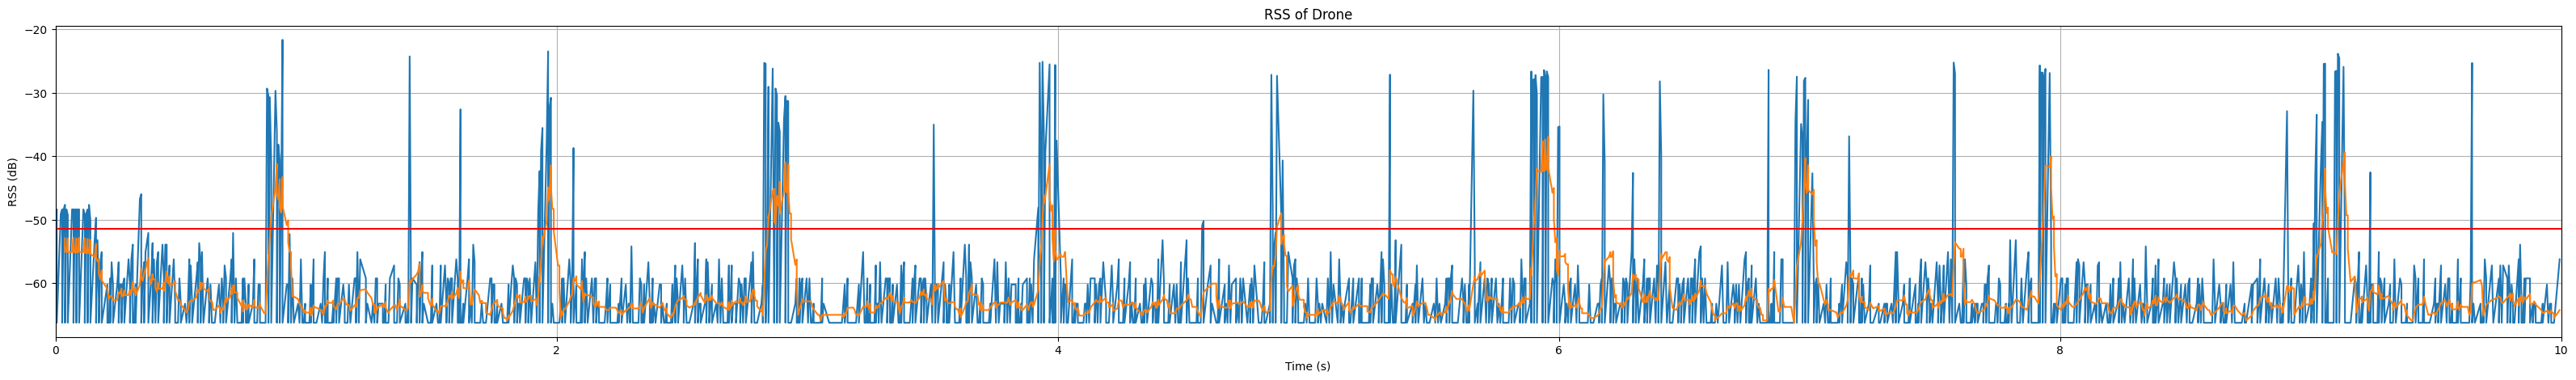

In [214]:
plt.figure(figsize=(40, 5))
plt.plot(drone['time'], drone['rss'])
# plt.plot(drone[3], drone[2])
plt.plot(drone['time'], drone['rolling_rss'])
plt.axhline(y = average, color = 'r', linestyle = '-')
plt.title('RSS of Drone')
plt.xlabel('Time (s)')
plt.xlim([0, 10])
plt.ylabel('RSS (dB)')
plt.grid(True)
plt.show()

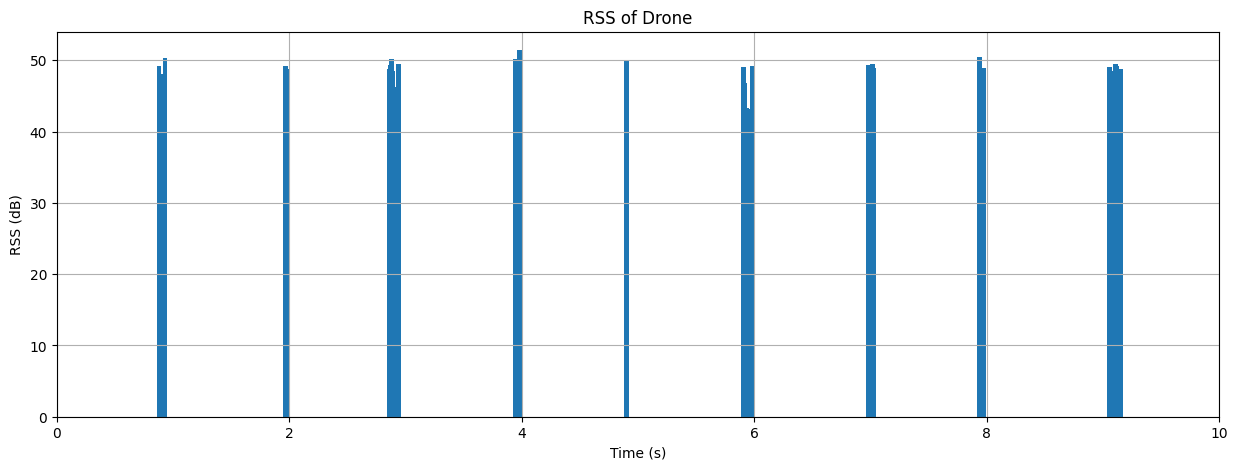

In [193]:
plt.figure(figsize=(15, 5))
# plt.plot(drone['time'], drone['rss'])
plt.bar(parts['time'], parts['rolling_rss'], width=.04)
plt.title('RSS of Drone')
plt.xlabel('Time (s)')
plt.xlim([0, 10])
plt.ylabel('RSS (dB)')
plt.grid(True)
plt.show()

# IQ samples

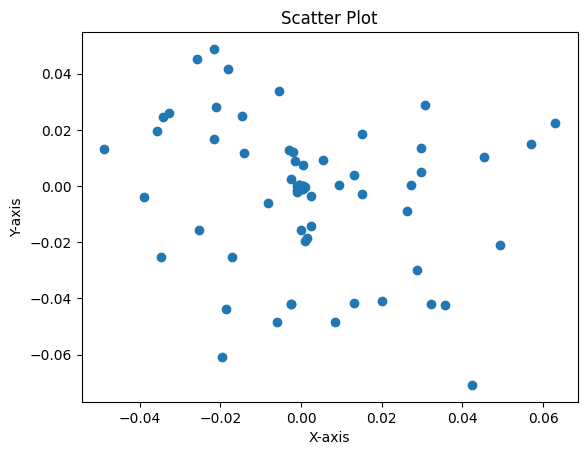

In [218]:
plt.scatter(parts[parts['rolling_rss'] > 0]['i'], parts[parts['rolling_rss'] > 0]['q'])

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Drone IQ samples')
plt.show()

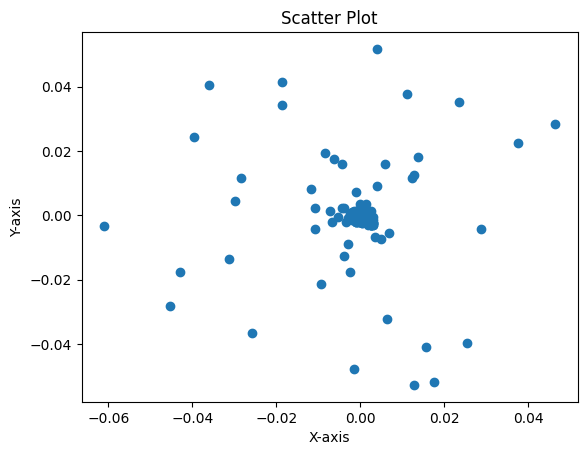

In [219]:
plt.scatter(parts[parts['rolling_rss'] <= 0]['i'], parts[parts['rolling_rss'] <= 0]['q'])

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot')
plt.show()

<PolarAxes: >

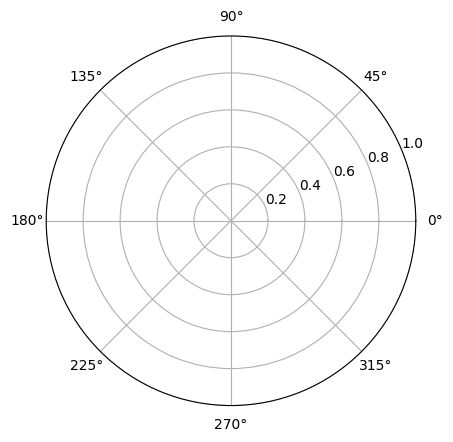

In [189]:
plt.subplot(polar=True)

In [23]:
def split_dataframe(df, column, threshold):
    parts = []
    start_idx = None
    
    for index, row in df.iterrows():
        if start_idx is None:
            if row[column] > threshold:
                start_idx = index
        elif row[column] <= threshold:
            parts.append(df.loc[start_idx:index-1])
            start_idx = None
    
    if start_idx is not None:
        parts.append(df.loc[start_idx:])
    
    return parts

In [24]:
result = split_dataframe(drone, 2, noise_floor)

result[0]

IndexError: list index out of range